Fs = 16000
0_mixed wav (17440, 22239)
0_mixed wav (16800,22879)
1_mixed wav (17440, 22239)
1_mixed wav (16800,22879)
2_mixed wav (17760, 21759)
2_mixed wav (17120,22399)
3_mixed wav (18560, 21439)
3_mixed wav (17920,22079)
4_mixed wav (17280, 22239)
4_mixed wav (16640,22879)
5_mixed wav (17440, 22239)
5_mixed wav (16800,22879)
6_mixed wav (17920, 21919)
6_mixed wav (17280,22559)
7_mixed wav (18080, 21599)
7_mixed wav (17440,22239)


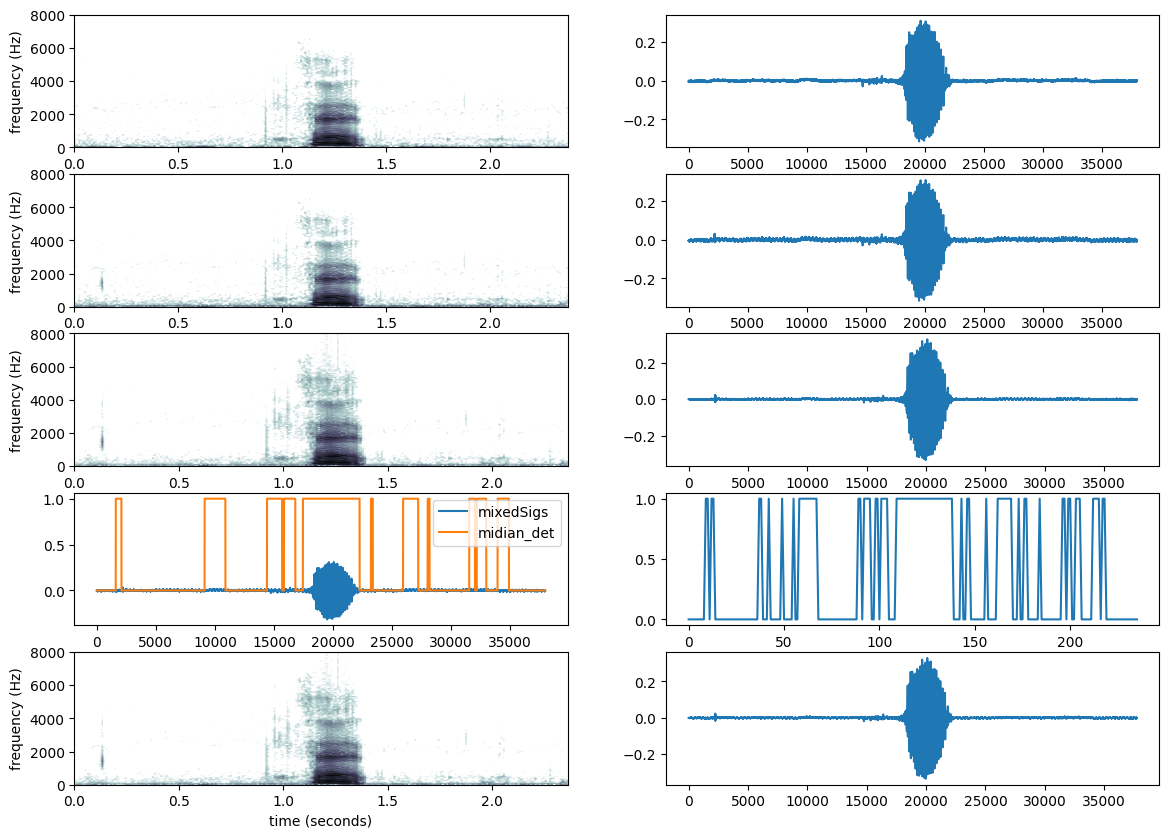

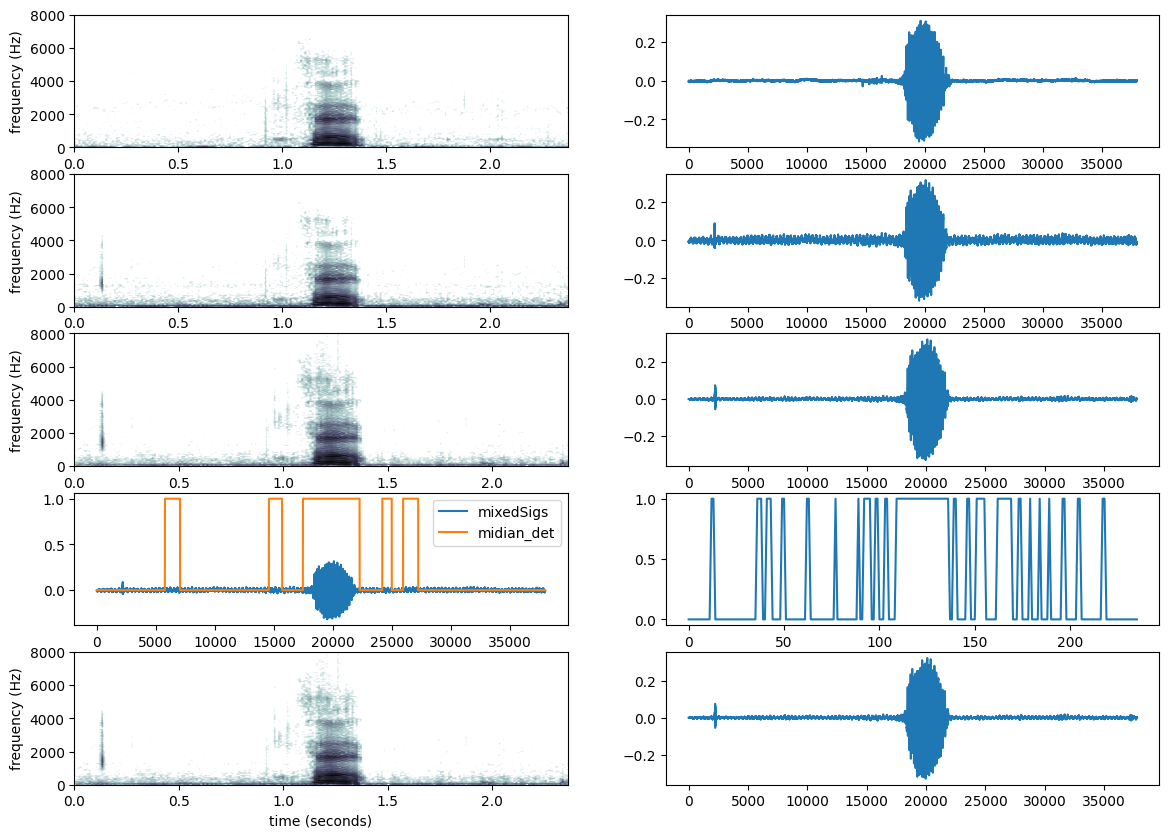

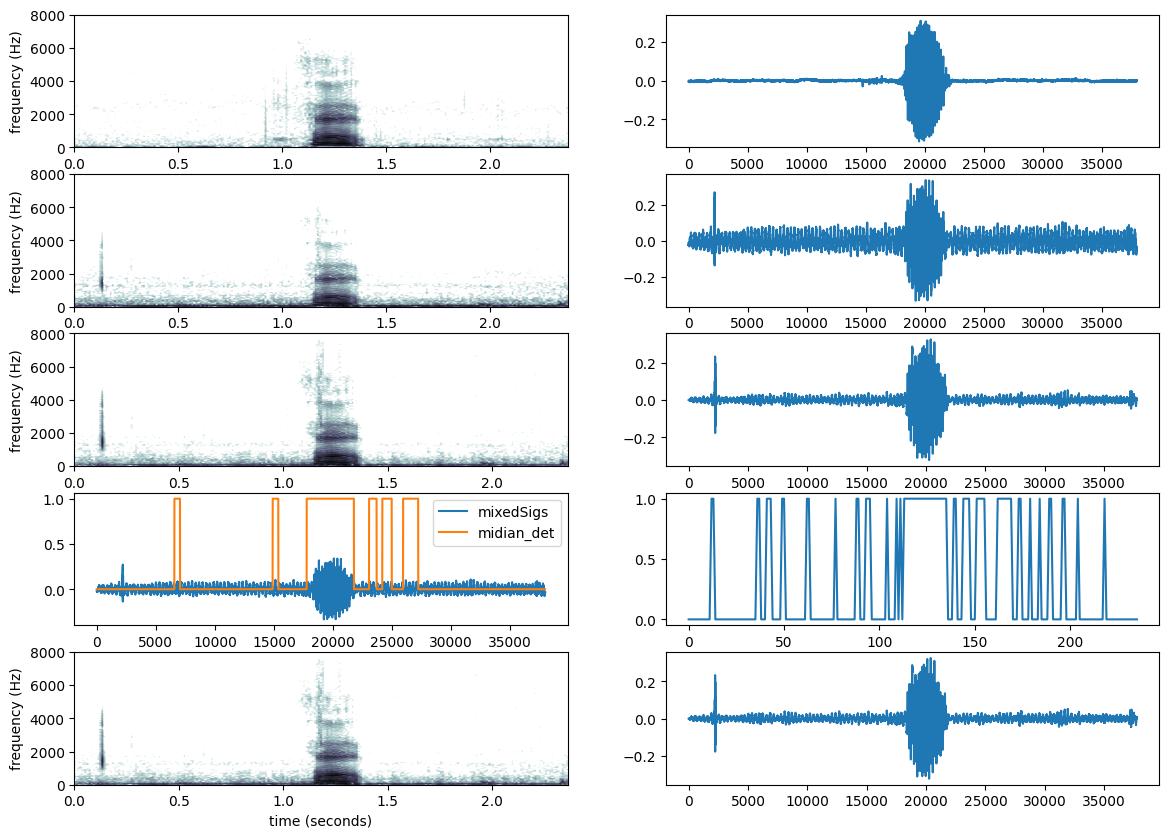

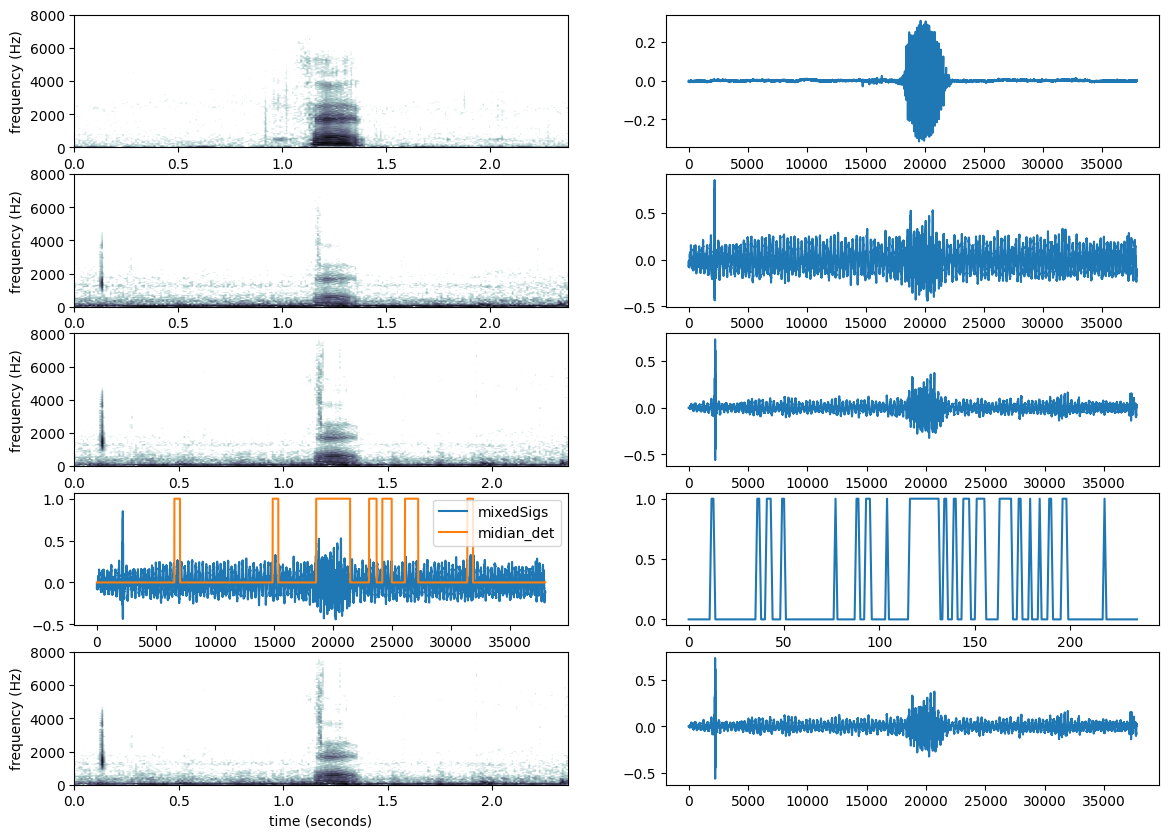

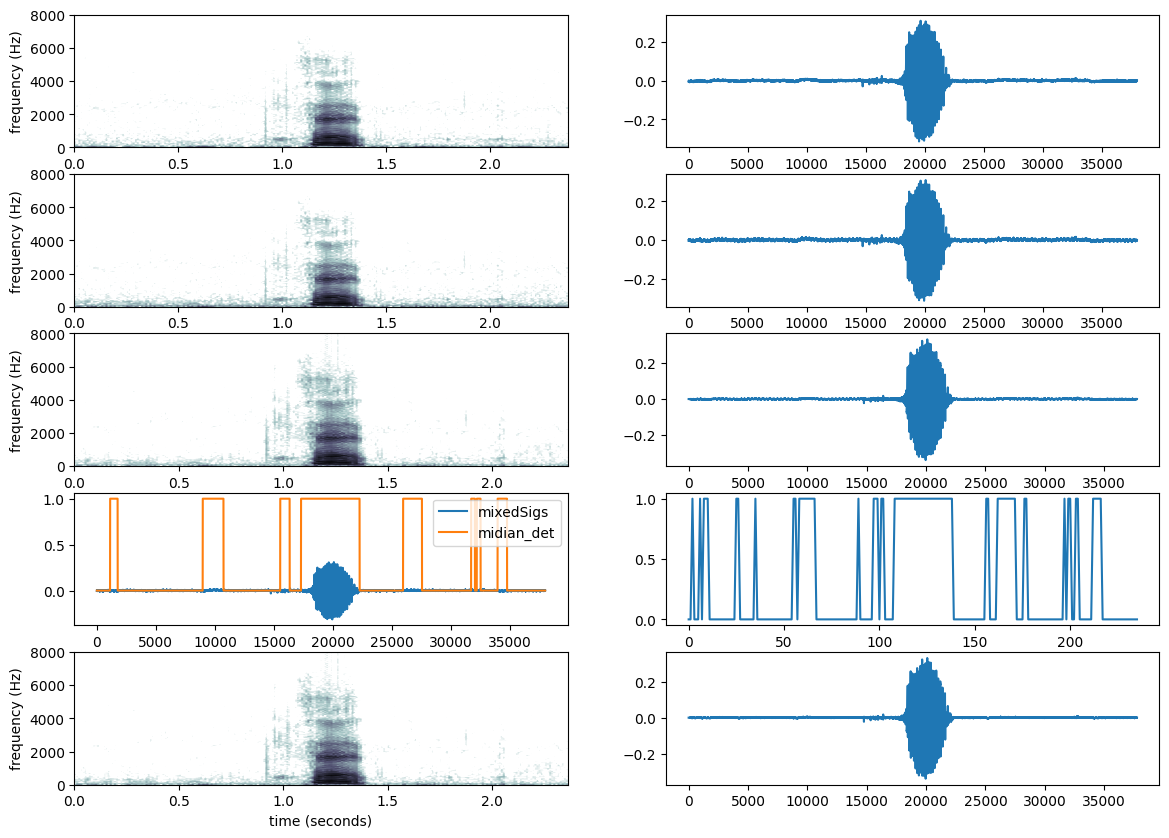

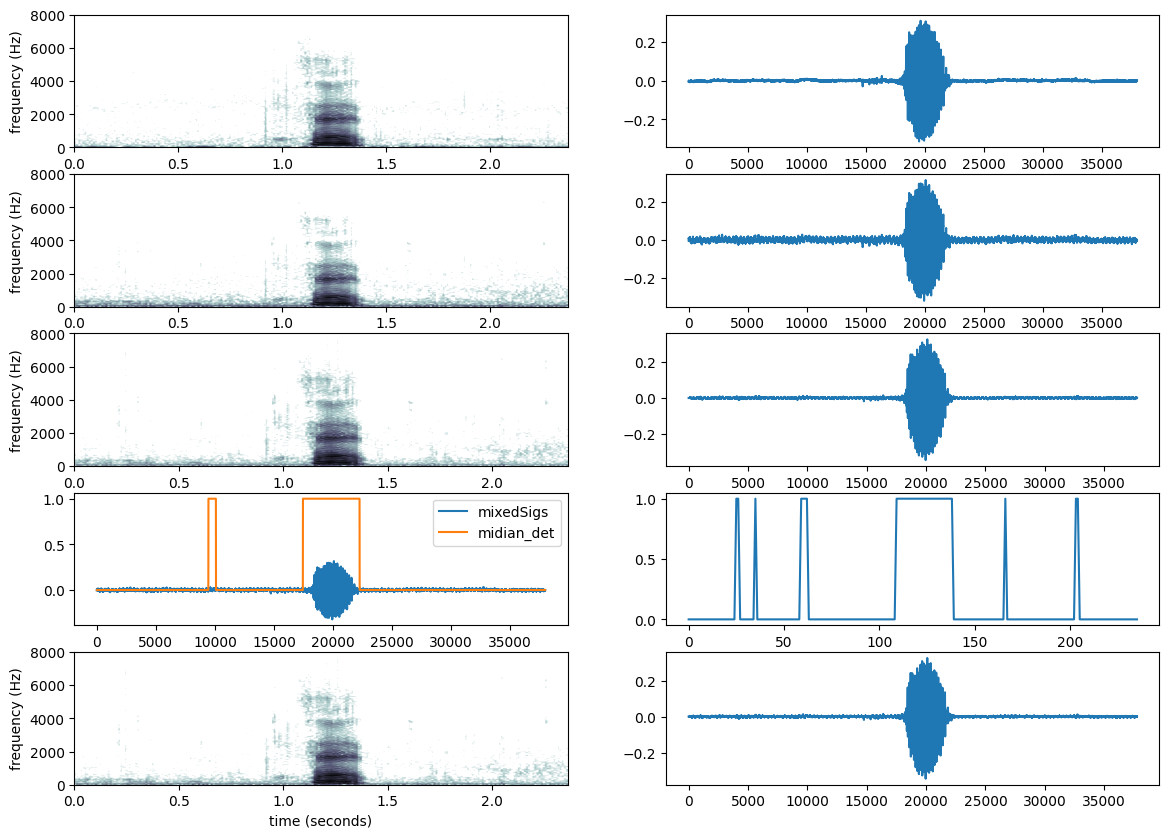

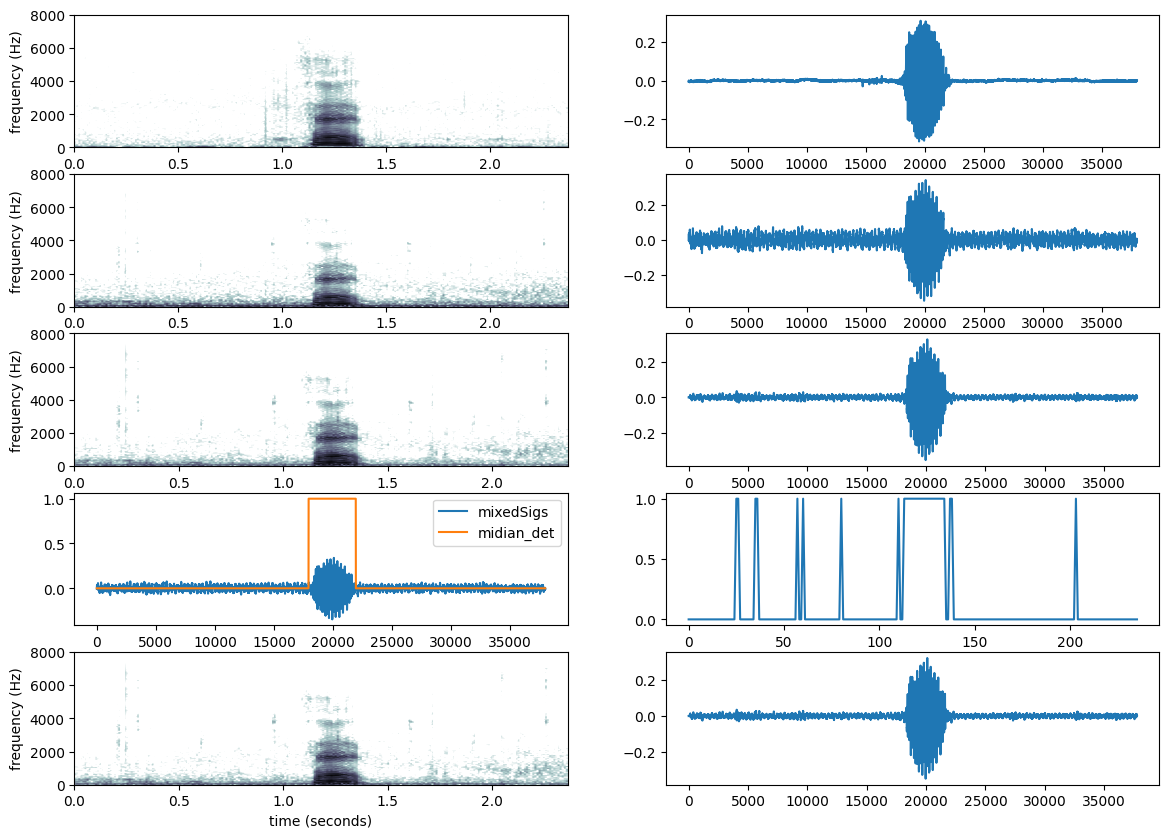

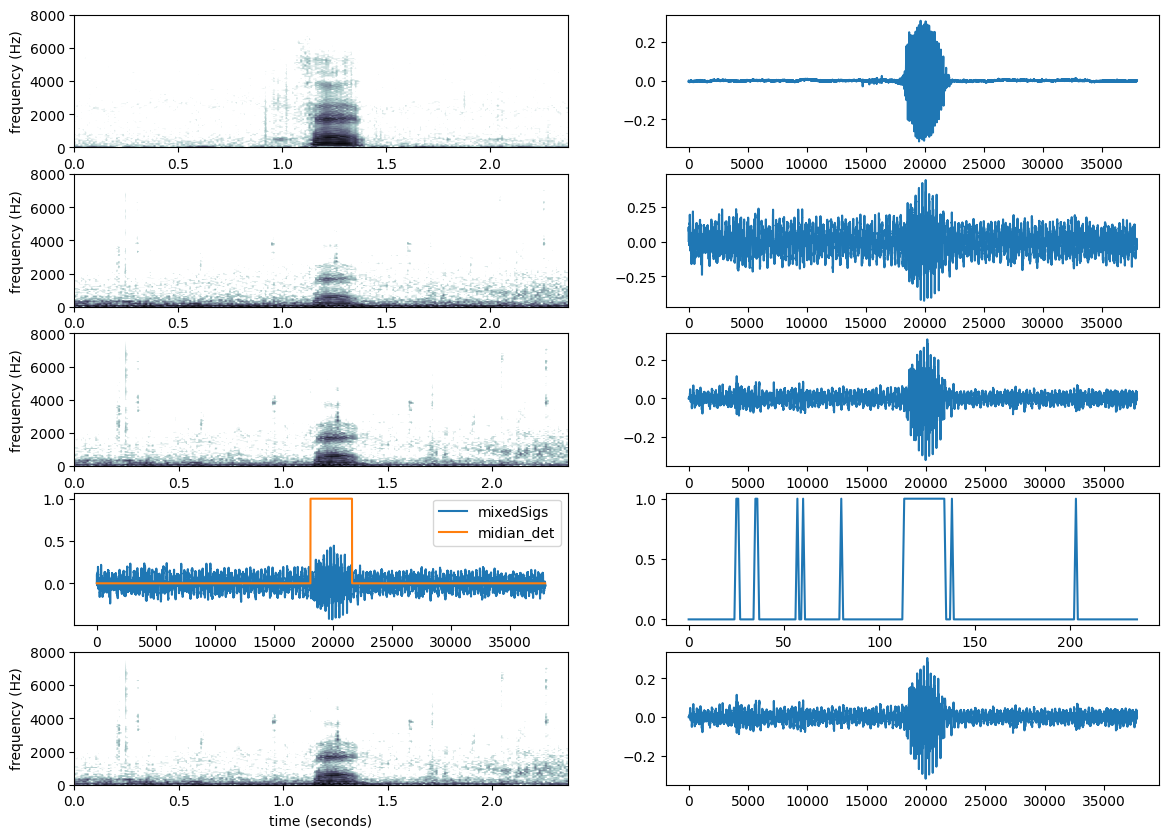

In [17]:
# 사용할 패키지들 정의
# import necessary packages
import sys
import numpy as np
import matplotlib
import librosa
from matplotlib import pyplot as plt

# from scipy.io import wavfile
from scipy import signal
from scipy.fft import fftshift

# display wav files
import IPython
from utils.gjfiroverlappadd import firoverlapadd
from utils.gjfiroverlappadd import getFIRFFT
from utils.gjdrawspectrogram3 import drawspectrogram3
import os

# 노이즈의 평균 에너지 계산.
def get_noise_energy(x, Ts, Tf, I, Fs):
    # x : speech signal
    # I : 노이즈 구간으로, 이는 stationary하기에 고정해서 생각해도 됨.
    Ns = int(Ts*Fs) # Ns : shift number of samples
    Nf = int(Tf*Fs) # Nf : Frame nubmer of samples
    # Nt = int(Tn*Fs) # Nn : noise number of samples, 앞선 것과는 다르게 임의의로 Tn은 0.5으로 잡아줌.
    Nt = int(I*Fs)

    # NFFT : # Nf보다 크거나 같은 2의 거듭제곱을 NFFT로 정의
    NFFT = int(2**(np.ceil(np.log2(Nf))))
    hNo = NFFT//2 + 1 # hNo : 
    Pnn = np.zeros(hNo) # Pnn : E[N*conj(N)]
    nframes = int((Nt-Nf)//Ns + 1) # nframes : 한 샘플당 전체 프레임의 갯수

    for n in range(nframes):
        y = x[(n*Ns):(n*Ns)+Nf]
        Y = np.fft.fft(y, NFFT)
        sqr_Y = (Y*np.conj(Y))
        Pnn += sqr_Y[:hNo].real

    return Pnn/nframes

# voice인지 noise인지 판단하는 Indicator 함수 
def determin_voice(x, Ts, Tf, Fs, Noise_Energy, rate=1.0):
    Ns = int(Ts*Fs)
    Nf = int(Tf*Fs)
    NFFT = int(2**(np.ceil(np.log2(Nf))))
    hNo = NFFT//2+1
    nframes = int((len(x)-Nf)//Ns+1)
    determin = np.zeros(nframes, dtype = float)

    threshold = np.sqrt(np.average(Noise_Energy)) * rate

    for i in range(nframes):
        y = x[(i*Ns):(i*Ns)+Nf]
        Y = np.fft.fft(y,NFFT)
        sqr_Y = (Y*np.conj(Y))
        # print(np.sqrt(np.average(sqr_Y[:hNo].real)))
        # print(threshold)
        if np.sqrt(np.average(sqr_Y[:hNo].real)) > threshold:
            determin[i] = 1.0

    return determin

# median filters
def midian_filter(x, len_filter=5) :
    wav = np.zeros(len(x))
    bi_len_filter = 0
    if len_filter%2 == 1:
        bi_len_filter = 1
    for i in range(len(x)) :
        wav[i] = np.median(np.concatenate([x[i-(len_filter//2):i], x[i:i+(len_filter//2)+bi_len_filter]]))
        
    return wav

# FIR Filter 적용
def FIR_filtering(x, Tf, Ts, Fs, Noise_Energy, order):
    Ns = int(Ts*Fs)
    Nf = int(Tf*Fs)
    NFFT = int(2**(np.ceil(np.log2(Nf))))
    hNo = NFFT//2 + 1 

    nframes = int((len(x)-Nf)//Ns + 1)
    pre_x = np.zeros(Ns)

    window =librosa.filters.get_window('hamming', Nf, fftbins=True)
    x_hat = np.zeros(Ns*nframes)

    for i in range(nframes):
        y = x[(i*Ns):(i*Ns)+Nf]
        Y = np.fft.fft(y, NFFT)
        sqr_Y = (Y*np.conj(Y))

        # (|X(w)|^2-|N(w)|^2)/|X(w)|^2 and
        # set bound (-3dB)
        H_w = (sqr_Y[:hNo].real - Noise_Energy)/sqr_Y[:hNo].real
        H_w = np.maximum(H_w, 0.224)

        h = getFIRFFT(np.array(H_w), order, winname='hamming')
        x2 = signal.lfilter(h, [1], x[(i*Ns):(i*Ns)+Nf])
        # print(f' size of window : {len(window)}')
        # print(f' size of x2 : {len(x2)}')

        x2 = x2*window
        x_hat[i*Ns:((i+1)*Ns)] = x2[:Ns]+pre_x
        pre_x = x2[-Ns:] # 그 전 프레임의 마지막 꺼를 붙여서 

    return x_hat

# End Point Detection
def End_Point_Detection(x, Ts, Tf, Fs, Noise_Energy):
    Ns = int(Ts*Fs)
    det = determin_voice(x, Ts, Tf, Fs, Noise_Energy, 1.2) # threshold를 노이즈 평균의 1.2로 계산함

    # indicator 함수에서 처리한 신호를 midian filter를 통과시킴 
    det_middian = midian_filter(det)

    # 음성 구간을 찾기 위해서, 가장 긴 구간을 먼저 탐색함.
    max_len = 0 
    checking = False
    start_point = 0
    end_point = 0

    for i in range(len(det_middian)):
        if det_middian[i] == 1.0 and not checking :
            checking = True
            temp_len = Ns
            temp_start = i*Ns

        elif det_middian[i] == 1.0 and checking :
            temp_len = temp_len + Ns
        
        elif ((det_middian[i] == 0.0) or i == len(det_middian)-1) and checking :
            checking = False
            if temp_len > max_len:
                max_len = temp_len
                start_point = temp_start
                end_point = (i*Ns) - 1
                if i == len(det_middian)-1 :
                    end_point = ((i+1)*Ns) - 1

    return det, det_middian, start_point, end_point

# add '/' if path is not a null string
def addpath(path, file):
    if len(path) == 0: 
        return file
    else:
        return path + '/' + file

def get_Noise_avg(x, Tf, Ts, I, Fs, start, end):
    # x : speech signal
    # I : 노이즈 구간으로, 이는 stationary하기에 고정해서 생각해도 됨.
    Ns = int(Ts*Fs) # Ns : shift number of samples
    Nf = int(Tf*Fs) # Nf : Frame nubmer of samples
    # Nt = int(Tn*Fs) # Nn : noise number of samples, 앞선 것과는 다르게 임의의로 Tn은 0.5으로 잡아줌.
    Nt = int(I*Fs)

    # NFFT : # Nf보다 크거나 같은 2의 거듭제곱을 NFFT로 정의
    NFFT = int(2**(np.ceil(np.log2(Nf))))
    hNo = NFFT//2 + 1 # hNo : 
    Pnn = np.zeros(hNo) # Pnn : E[N*conj(N)]
    nframes = int((Nt-Nf)//Ns + 1) # nframes : 한 샘플당 전체 프레임의 갯수

    count = 0
    for n in range(nframes):
        if n*Ns >= start and n*Ns <= end:
            continue
        y = x[(n*Ns):(n*Ns)+Nf]
        Y = np.fft.fft(y, NFFT)
        sqr_Y = (Y*np.conj(Y))
        Pnn += sqr_Y[:hNo].real
        count += 1
        
    return Pnn/count 

def main():
    audioinputpath = './audio'
    speechfile = addpath(audioinputpath,'gjang-kdigits0-3.wav')
    noisefiles = [addpath(audioinputpath,'audio_car.wav'), addpath(audioinputpath,'audio_car2.wav')]

    order = 62
    sr = 16000
    Ts = 0.01
    Tf = 0.02

    FIG_SIZE = (14,10)
    # FIG_SIZE = (8,3)

    
    # to load speech and noise files
    speech, Fs = librosa.load(speechfile, sr=sr)
    print(f'Fs = {Fs}')

    noises = []
    for i in range(len(noisefiles)):
        noise, _ = librosa.load(noisefiles[i], sr=sr)
        noises.append(noise)

    # to get the standard deviations about signal, noises 
    # and make the mixed wavefiles.
    std_s = np.sqrt(np.mean(speech**2))
    mixsnrs = np.array([20, 10, 0, -10])
    std_n = []
    for i in range(len(noises)) :
        std_n.append(np.std(noises[i]))
    std_n = np.array(std_n)
    mixedSigs = []

    for i in range(len(noises)):
        for snr in mixsnrs :
            gain = np.power(10, -snr/20)
            gn = noises[i][:len(speech)]/std_n[i]*std_s*gain
            m = speech + gn
            mixedSigs.append(m)
            
    # Nf = int(Tf*Fs)
    # Ns = int(Ts*Fs)
    # NFFT = int(2**(np.ceil(np.log2(Nf))))
    # cmap_plot = plt.cm.bone_r
    
    for num in range(len(mixedSigs)):
    # for num in range(1):
        # 음성파일 plot하기
        plt.figure(figsize=FIG_SIZE)
        plt.subplot(5,2,1)
        sig = drawspectrogram3(speech, Fs, int(Tf*Fs))
        # sig = drawspectrogram3.drawspectrogram3(speech, Fs, NFFT, Ns, minpercentile=1, isdbscale=True, isdraw=True, colormap=cmap_plot)

        plt.subplot(5,2,2)
        # plt.plot(speech); plt.xlim(0,len(speech)); plt.ylim(-0.5,0.5); plt.xticks([0, len(speech)])
        plt.plot(speech)

        # 합성된 음성파일 plot하기
        plt.subplot(5,2,3)
        ns = drawspectrogram3(mixedSigs[num], Fs, int(Tf*Fs))

        plt.subplot(5,2,4)
        plt.plot(mixedSigs[num])

        # 1. 입력신호의 프레임별 absolute Energy를 구함.
        I_noise = 0.5
        Noise_Energy = get_noise_energy(mixedSigs[num], Ts, Tf, I_noise, Fs)
        
        # 2. 앞서 구한 abosutl enery를 이용하여, Linear-phase FIR filter를 구하고 적용한다.
        sig_hat = FIR_filtering(mixedSigs[num], Tf, Ts, Fs, Noise_Energy, order)
        plt.subplot(5,2,5)
        sig_filtering = drawspectrogram3(sig_hat, Fs, int(Tf*Fs))

        plt.subplot(5,2,6)
        plt.plot(sig_hat)
        
        # 3. EPD(End-Point-Detection) 구현
        (det, midian_det, start_point, end_point) = End_Point_Detection(mixedSigs[num], Ts, Tf, Fs, Noise_Energy)
        
        midian_det_plot = np.zeros(len(mixedSigs[num]),dtype=float)
        for i in range(len(midian_det)):
            midian_det_plot[i*int(Ts*Fs):(i+1)*int(Ts*Fs)] = midian_det[i]

        # 3-1. midian filter가 적용된 spectrogram
        plt.subplot(5,2,7)
        plt.plot(mixedSigs[num])
        plt.plot(midian_det_plot)
        plt.legend(('mixedSigs','midian_det'))

        # 3-2. midian filter가 적용되지 않은 spectrogram
        plt.subplot(5,2,8)
        plt.plot(det)

        print(f'{num}_mixed wav ({start_point}, {end_point})')

        # 무성자음 및 fading-out 포함(40ms)
        padding = 0.04

        # reference : 후행하는 유,무성 장므에 의한 모음의 지속시간 고찰.
        start_point = np.maximum(start_point-int(padding*Fs), 0) 
        end_point = np.minimum(end_point + int(padding*Fs), len(mixedSigs[num])-1)
        print(f'{num}_mixed wav ({start_point},{end_point})')

        # 모든 Noise 구간에 대하여 |N(w)|^2 계산

        N_all = get_Noise_avg(mixedSigs[num], Tf, Ts, I_noise, Fs, start_point, end_point)
        # 모든 Noise 구간에 대한 |N(w)|^2으로 FIR filter 적용
        x_hat2 = FIR_filtering(mixedSigs[num], Tf, Ts, Fs, N_all, order)
        plt.subplot(5,2,9)
        x2 = drawspectrogram3(x_hat2, Fs, int(Tf*Fs))
        plt.subplot(5,2,10)
        plt.plot(x_hat2)

if __name__ == '__main__':
    main()
        